Author: Alexander Criswell \<<alexander.criswell@ligo.org>\>

This notebook is designed as a tutorial for working with the Hierarchical Bayesian Post-merger Analysis as outlined in [insert paper link here]. It is not comprehensive but will hopefully be helpful. It covers the basic use cases of the code written for this analysis, both via the modules provided in hbpm_utils and via the more convenient, but somewhat less flexible run_analysis function of hbpm_analysis.py. The specific case presented here is individual + combined analyses of simulated realizations of the (at time of writing) next two LVK observing runs (O4 and O5). At the end there are instructions for running the analysis via a command line interface.

In [1]:
## basic imports
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import scipy.stats as st
import matplotlib
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde as kde
from scipy.stats.mstats import mquantiles as mq
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde
from glob import glob
import pandas as pd
import sys 
import os
import pickle

## Importing the accompanying utility and analysis files
sys.path.append(os.path.abspath('../hbpm_utils/'))
from hbpm_utils import *
from importlib import reload
reload(sys.modules["hbpm_utils"])
from hbpm_utils import *
sys.path.append(os.path.abspath('..'))
from hbpm_analysis import run_analysis
reload(sys.modules["hbpm_analysis"])
from hbpm_analysis import run_analysis

## my preferred figure settings
matplotlib.rcParams['figure.figsize'] = (8.08, 5.)
matplotlib.rcParams['xtick.labelsize'] = 12.0
matplotlib.rcParams['ytick.labelsize'] = 12.0
matplotlib.rcParams['axes.labelsize'] = 14.0
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["mediumorchid", "teal", "goldenrod","slategray"])

## Preliminaries
Here, we will set up our priors and specify various resources needed for the analysis.

In [4]:
## fine grid
fs = np.linspace(1.5,4,200)
Ms = np.linspace(0.8,1.8,200)

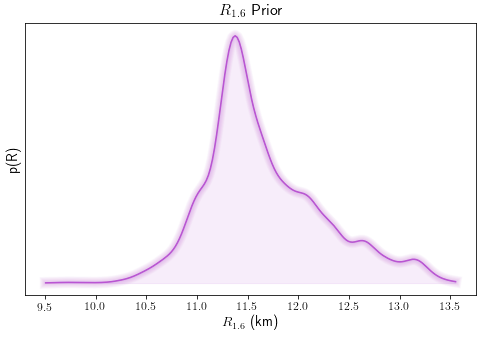

In [5]:
## get the Dietrich et al. (2020) multimessenger prior for R_1.6
Rs, Rprior_kernel, R16samples = load_Rprior('../priors/R16_prior.txt',return_samples=True)

In [6]:
## get the O4/O5 fpeak prior
fprior_path = '../priors/fpeak_O4O5_prior.txt'
fprior_samples = np.loadtxt(fprior_path)
fprior = Prior_f(fprior_samples,boundary='Reflection')

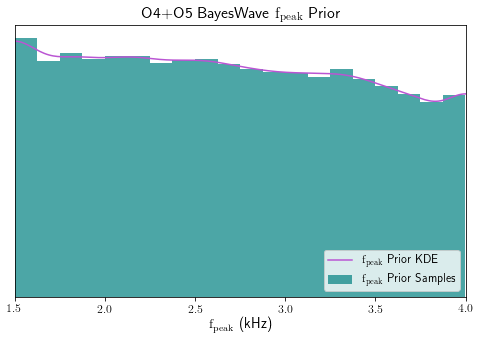

In [6]:
## plot the fpeak prior
plt.figure()
plt.plot(fs,fprior.pdf(fs),label='$\\mathrm{f_{peak}}$ Prior KDE')
plt.hist(fprior.samples,density=True,alpha=0.7,label='$\mathrm{f_{peak}}$'+' Prior Samples',bins=20)
plt.xlabel('$\mathrm{f_{peak}}$ (kHz)')
plt.xlim(1.5,4)
plt.yticks([])
plt.title('O4+O5 BayesWave $\mathrm{f_{peak}}$ Prior')
plt.legend(loc='lower right')
# plt.savefig('./tutorial_outputs/fpeak_prior_O4O5.png',bbox_inches='tight')
plt.show()

# BayesWave Analyses

We now have prior samples and distributions for $f_{peak}$ and $R_{1.6}$, so let's load a simulation of the (at time of writing) next to LVK observing runs, O4 and O5. 

In [7]:
## instantiate rng
rng = np.random.default_rng(170817)

In [8]:
## load data
## the datadirs contain individual post-merger peak frequency posterior samples from BayesWave
O4_datadir = '../observing_run_sims/O4_sim/'
O4_events = glob(O4_datadir+'/sfhx_*')
O5_datadir = '../observing_run_sims/O5_sim/'
O5_events = glob(O5_datadir+'/sfhx_*')
## the ev_df has the original numerical relativity simulation parameters
ev_df_path = '../nr_files/sfhx_event_parameters.csv'
sfhx_ev_df = pd.read_csv(ev_df_path)
## the observing run sim_df files have the simulated observed inspiral parameters
O4_csv_path = '../observing_run_sims/O4_events_updated.csv'
O4_sim_df = pd.read_csv(O4_csv_path)
O5_csv_path = '../observing_run_sims/O5_events_updated.csv'
O5_sim_df = pd.read_csv(O5_csv_path)

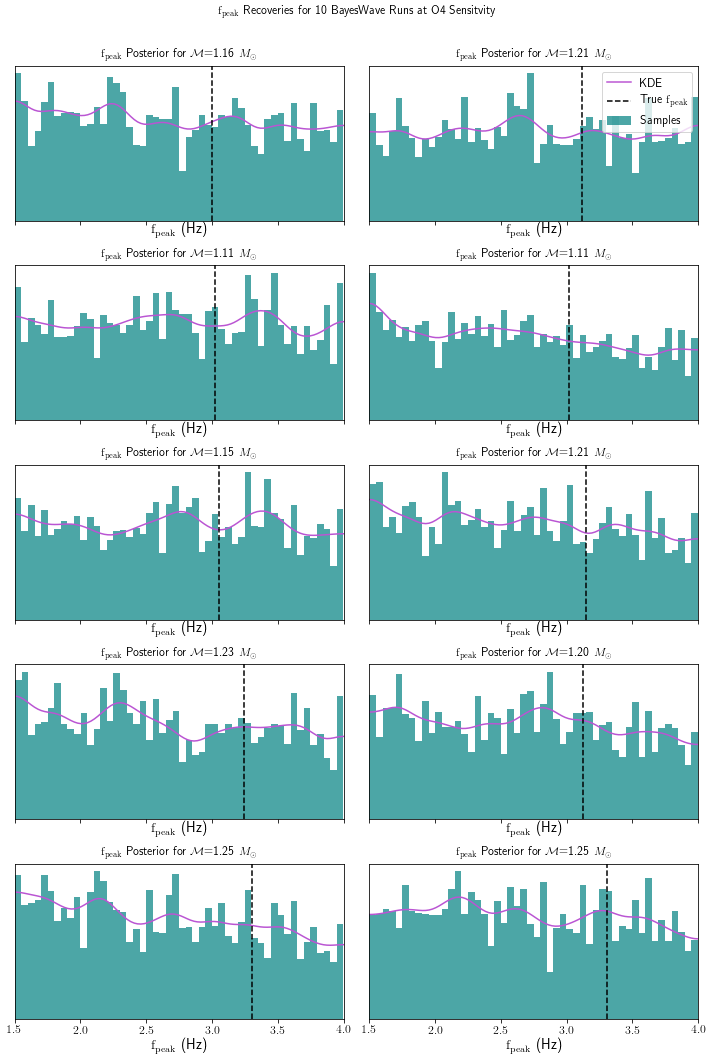

In [9]:
## gen_BayesWave_eventdict packages all info needed for the analysis into a dictionary
O4_eventdict= gen_BayesWave_eventdict(O4_events,sfhx_ev_df,170817,kde_boundary='Reflection',plot='subset',
                                      use_prior='no',prior=fprior.samples,obs_run=True,sim_df=O4_sim_df,
                                      title='$\mathrm{f_{peak}}$ Recoveries for 10 BayesWave Runs at O4 Sensitvity')


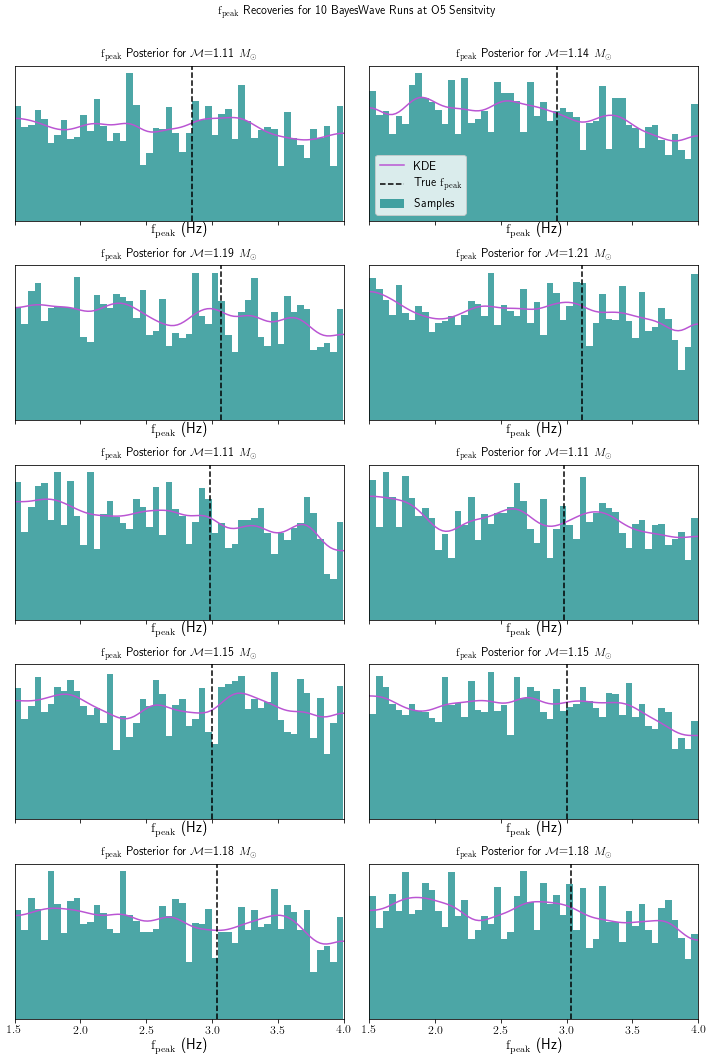

In [10]:
## do the same for O5
O5_eventdict= gen_BayesWave_eventdict(O5_events,sfhx_ev_df,170817,kde_boundary='Reflection',plot='subset',
                                      use_prior='no',prior=fprior.samples,obs_run=True,sim_df=O5_sim_df,
                                      title='$\mathrm{f_{peak}}$ Recoveries for 10 BayesWave Runs at O5 Sensitvity')

Now we can compute the individual event likelihoods. For this example, we approximate the chirp mass posteriors as normal distributions around their true values, but in a production analysis, we would use chirp mass posterior samples from e.g. Bilby or LALInference.

In [11]:
likes_O4 = get_multievent_likelihoods(Rs,Ms,O4_eventdict,fprior=fprior,
                                          Mprior=st.uniform(loc=0,scale=10),Mchirp_scaling='snr')

Processing event 1/26 (Mc=1.16 Mo)
Processing event 2/26 (Mc=1.21 Mo)
Processing event 3/26 (Mc=1.11 Mo)
Processing event 4/26 (Mc=1.11 Mo)
Processing event 5/26 (Mc=1.15 Mo)
Processing event 6/26 (Mc=1.21 Mo)
Processing event 7/26 (Mc=1.23 Mo)
Processing event 8/26 (Mc=1.20 Mo)
Processing event 9/26 (Mc=1.25 Mo)
Processing event 10/26 (Mc=1.25 Mo)
Processing event 11/26 (Mc=1.17 Mo)
Processing event 12/26 (Mc=1.20 Mo)
Processing event 13/26 (Mc=1.20 Mo)
Processing event 14/26 (Mc=1.18 Mo)
Processing event 15/26 (Mc=1.22 Mo)
Processing event 16/26 (Mc=1.25 Mo)
Processing event 17/26 (Mc=1.25 Mo)
Processing event 18/26 (Mc=1.24 Mo)
Processing event 19/26 (Mc=1.24 Mo)
Processing event 20/26 (Mc=1.25 Mo)
Processing event 21/26 (Mc=1.25 Mo)
Processing event 22/26 (Mc=1.25 Mo)
Processing event 23/26 (Mc=1.25 Mo)
Processing event 24/26 (Mc=1.25 Mo)
Processing event 25/26 (Mc=1.25 Mo)
Processing event 26/26 (Mc=1.25 Mo)


And that's that! Now we can investigate the inferred posterior distribution for O4. hbpm_utils has a number of plotting functions. All plotting functions default to display only, but will save the plot if saveto= is specified.

For the neutron star equation of state (SFHX) used for the waveforms in these simulations, $R_{1.6}=11.98$ km.

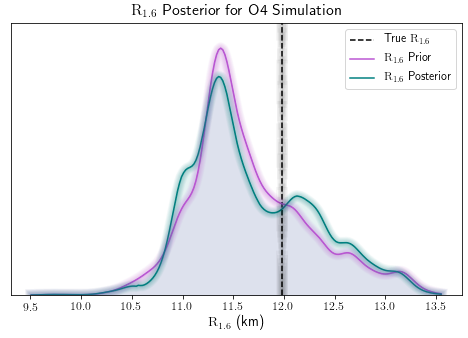

In [12]:
plot_aggregate_posterior(Rs,likes_O4,Rprior_kernel,Rtrue=11.98,glow=True,
#                          saveto='./tutorial_outputs/O4_simulation_posterior.png',
                         title='$\mathrm{R_{1.6}}$ Posterior for O4 Simulation')

We can also look at how the posterior changes with number of events:

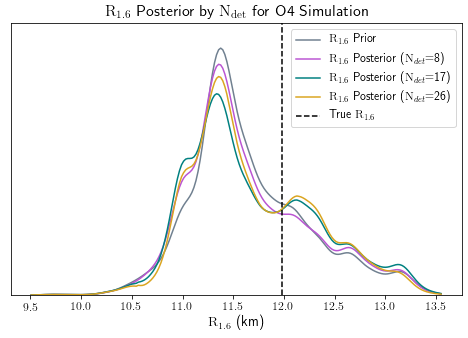

In [13]:
## evolution with N_events
Ns = [8,17,26]
plot_posterior_by_Nevents(Rs,likes_O4,Rprior_kernel,Ns,Rtrue=11.98,glow=False,
#                           saveto='./tutorial_outputs/O4_simulation_posterior_evolution.png',
                          title='$\mathrm{R_{1.6}}$ Posterior by $\mathrm{N_{det}}$ for O4 Simulation')

There is also a function for easily computing the posterior mean and 95% confidence interval:

In [14]:
## some quick stats
post_O4 = get_posterior(Rs,get_aggregate_likelihood(likes_O4),Rprior_kernel)
O4_mean, O4_low, O4_high = get_post_stats(post_O4,Rs)

R_1.6 = 11.69 (+1.35,-0.92) km


Now we do the same process for O5. Setting verbose=False suppresses the progress messages we saw while analyzing the O4 data. (This is useful because there are many more events in O5!)

In [15]:
likes_O5 = get_multievent_likelihoods(Rs,Ms,O5_eventdict,fprior=fprior,
                                          Mprior=st.uniform(loc=0,scale=10),Mchirp_scaling='snr',verbose=False)

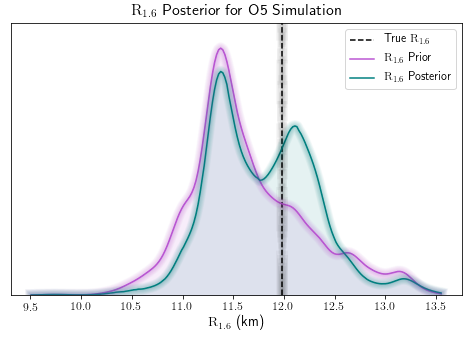

In [16]:
plot_aggregate_posterior(Rs,likes_O5,Rprior_kernel,Rtrue=11.98,glow=True,
#                          saveto='./tutorial_outputs/O5_simulation_posterior.png',
                         title='$\mathrm{R_{1.6}}$ Posterior for O5 Simulation')

Now we want to save our results using save_posterior_eventdict(). This will save a .pickle file containing all the information needed to reproduce the analysis. It will also generate the dictionary equivalent of this .pickle for immediate use, as we have specified return_dict=True.

In [18]:
## save O4
O4_post_dict = save_posterior_eventdict(O4_events,O4_eventdict,sfhx_ev_df,likes_O4,R16samples,Rs,
                                        './tutorial_outputs/O4_results.pickle','BayesWave',returndict=True)

Saved file to ./tutorial_outputs/O4_results.pickle


In [19]:
## save O5
O5_post_dict = save_posterior_eventdict(O5_events,O5_eventdict,sfhx_ev_df,likes_O5,R16samples,Rs,
                                        './tutorial_outputs/O5_results.pickle','BayesWave',returndict=True)

Saved file to ./tutorial_outputs/O5_results.pickle


We can also load a previous recovery:

In [20]:
loaded_O5_post_dict = load_posterior_pickle('./tutorial_outputs/O5_results.pickle')

This dictionary has sub-dictionaries for each event, as well as information about the Equation of State ('eos'), R16 values at which each event likelihood is evaluated ('Rs') and the prior used ('prior').

In [21]:
loaded_O5_post_dict.keys()

dict_keys(['eos', 'Rs', 'prior', '118138_151.96', '121143_360.32', '123153_767.69', '124156_432.25', '125131_158.29', '125131_41.91', '125139_194.45', '125139_630.97', '125147_253.82', '125147_502.66', '127133_626.26', '127141_505.15', '127149_455.68', '128128_200.18', '128160_375.33', '128160_460.50', '128160_460.50-2', '129143_115.77', '129143_243.16', '129143_314.81', '129143_490.61', '130154_288.15', '131137_272.74', '131137_438.01', '131145_282.94', '132156_239.17', '132156_287.83', '132156_418.41', '132156_532.61', '132156_684.70', '132156_702.42', '132156_853.60', '133139_139.52', '133139_205.58', '133139_256.67', '133139_424.16', '133139_470.00', '133147_287.31', '134134_235.33', '134134_313.19', '135149_161.03', '136144_390.65', '136144_475.07', '136144_570.44', '136144_62.65', '136144_776.69', '136152_192.91', '136152_210.22', '136152_516.60', '136152_522.92', '136152_567.19', '136152_570.49', '136152_576.89', '136152_621.35', '136152_636.17', '136152_649.88', '136152_824.60'

Each event's sub-dictionary contains a wealth of information about that particular event:

In [22]:
loaded_O5_post_dict['134134_235.33'].keys()

dict_keys(['mchirp', 'dist', 'ftrue', 'snr', 'event_type', 'fchains', 'likelihood_i', 'waveform'])

These posterior dictionaries have a standard format, which allows us to merge them without hassle if we want to investigate their combined information:

In [23]:
O4O5_post_dict = {**O4_post_dict,**O5_post_dict}

Of course, you should only do this if the analyses share an EoS, R range ('Rs'), and R16 prior, as merging the dictionaries only keeps one set of any duplicate keys.

In [25]:
O4O5_post_dict.keys()

dict_keys(['eos', 'Rs', 'prior', '123145_275.58', '124156_325.94', '128128_213.20', '128128_295.96', '129135_135.38', '129151_316.01', '130154_347.93', '131145_126.60', '132156_205.15', '132156_540.00', '134134_280.52', '134142_182.19', '134142_387.55', '136136_164.17', '136144_354.33', '136152_177.59', '136152_552.23', '138146_346.51', '138146_520.08', '140148_340.87', '140148_425.59', '140148_566.84', '144144_112.80', '144144_307.16', '144144_372.57', '144144_944.19', '118138_151.96', '121143_360.32', '123153_767.69', '124156_432.25', '125131_158.29', '125131_41.91', '125139_194.45', '125139_630.97', '125147_253.82', '125147_502.66', '127133_626.26', '127141_505.15', '127149_455.68', '128128_200.18', '128160_375.33', '128160_460.50', '128160_460.50-2', '129143_115.77', '129143_243.16', '129143_314.81', '129143_490.61', '130154_288.15', '131137_272.74', '131137_438.01', '131145_282.94', '132156_239.17', '132156_287.83', '132156_418.41', '132156_532.61', '132156_684.70', '132156_702.42

We can now consider the combined posterior. First unpack the combined dictionary:

In [30]:
Rs_O4O5, Rprior_kernel_O4O5, likes_O4O5 = unpack_posterior_dict(O4O5_post_dict)

(we can use either the new or old Rs/R16prior, they're identical)

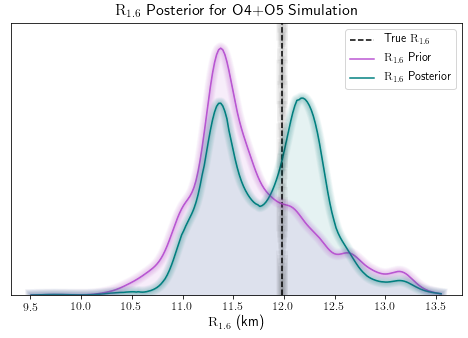

In [31]:
plot_aggregate_posterior(Rs,likes_O4O5,Rprior_kernel,Rtrue=11.98,glow=True,
#                          saveto='./tutorial_outputs/O4O5_simulation_posterior.png',
                         title='$\mathrm{R_{1.6}}$ Posterior for O4+O5 Simulation')

With these posterior dictionaries, we can also do easy 3-panel plots. Just build a dictionary with each version of the analysis and accompanying labels:

In [41]:
O4O5_multi_dict = {'O4':O4_post_dict,'O5':O5_post_dict,'O4O5':O4O5_post_dict}

And plot! 'sensitivities' should be the keys you assigned in the above multi_dict. For dictionaries made in this way, we need to specified dict_type='raw'.

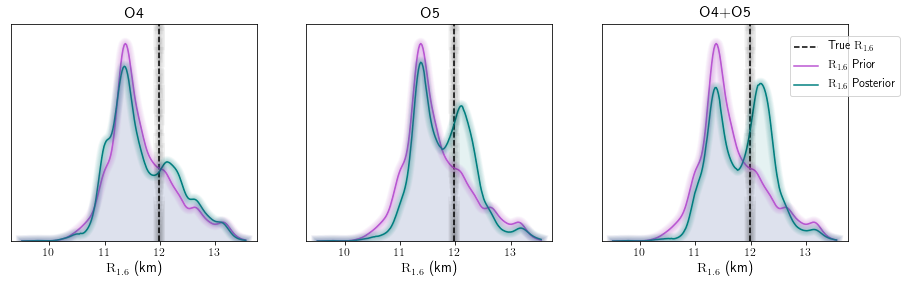

In [42]:
multiplot_3panel_post(Rs,O4O5_multi_dict,Rprior_kernel,sensitivities=['O4','O5','O4O5'],eoss=['sfhx'],
                      Rtruevals=[11.98],title=None,dist_cut=None,
#                       saveto='./tutorial_outputs/O4O5_multiplot_3panel.png',
                      legend_anchor=(0.74,.97),glow=True,
                      legend_loc=None,obs_run=True,dict_type='raw',legend_num='one')

# Ad-hoc Simulation
In addition to using BayesWave outputs, we can also run over purely simulated data. This allows us quite a bit of flexibility, so we can see how the analysis reacts under a variety of conditions.

In [33]:
## make a random selection on M = [0.85,1.88] M_sun using the rng we made earlier
M100 = rng.choice(np.linspace(0.85,1.88,500),size=100)
print(M100)

[0.92637275 1.33300601 1.37428858 1.61166333 1.47955912 1.39699399
 1.84284569 1.56418838 1.17819639 1.11008016 1.76647295 1.29997996
 1.79124248 1.35364729 1.83458918 1.34539078 1.42589178 0.93256513
 1.40112224 1.36603206 0.95527054 1.23186373 0.90779559 1.63024048
 1.64262525 0.86857715 1.22154309 0.85825651 1.4196994  1.30823647
 1.81601202 0.94701403 1.81601202 1.74170341 1.63849699 1.40937876
 1.57863727 1.03577154 1.33713427 1.27933868 1.01925852 1.36603206
 1.69835671 1.30410822 1.72725451 1.28140281 1.07705411 1.53116232
 0.89128257 1.23599198 1.27108216 0.89128257 1.47130261 1.13278557
 1.43002004 1.08118236 1.24012024 1.74170341 1.40937876 1.18438878
 0.91398798 0.88921844 1.15755511 1.48368737 1.85935872 1.23599198
 1.25456914 1.6240481  1.50845691 1.34539078 1.44034068 1.78711423
 1.82426854 1.82633267 1.51671343 1.0398998  0.91811623 1.31236473
 1.71486974 1.14723447 1.69216433 1.47543086 0.98416834 1.30410822
 1.49400802 1.51671343 1.0254509  1.78917836 1.718998   0.9552

The gen_simulated_eventdict() function creates an event dictionary like what we would get from loading BayesWave results, but with user-specified parameters. In this case, we're making a set of 100 weak fpeak recoveries, with 100 signal samples and 2400 uniform noise samples. We arbitrarily choose to set the "true" $\mathrm{R_{1.6}}$ to 12.5 km.

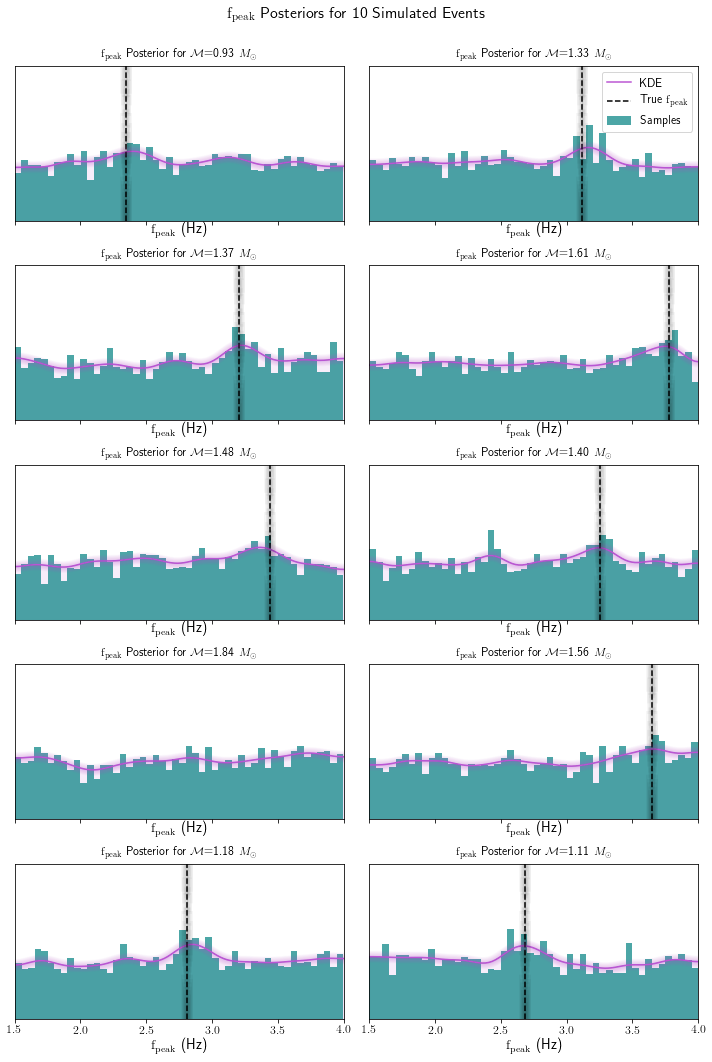

In [34]:
M100_weak_dict = gen_simulated_eventdict(M100,12.5,sigma_f=0.1,nsignal=100,nnoise=2400,
                                         rng=rng,plot='subset',kde_boundary='Reflection')

After this, the process is much the same as we've seen before. Note that because we are using uniform $\mathrm{f_{peak}}$ samples to represent noise, our $\mathrm{f_{peak}}$ prior must reflect that:

In [35]:
likes_M100_weak = get_multievent_likelihoods(Rs,Ms,M100_weak_dict,fprior=st.uniform(loc=1.5,scale=2.5),
                                             Mprior=st.uniform(loc=0,scale=10),verbose=False)

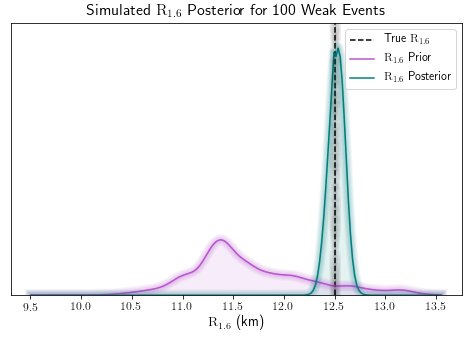

In [36]:
plot_aggregate_posterior(Rs,likes_M100_weak,Rprior_kernel,Rtrue=12.5,glow=True,
                         title='Simulated $\mathrm{R_{1.6}}$ Posterior for 100 Weak Events')

The result is, of course, much prettier than the more realistic analysis. We can save this result as we did before. However, we add the 'simulated' tag instead of 'BayesWave' to let our future selves/the code know how to handle this data. We don't care to mess with this further at the moment, so we option to not return the posterior event dictionary by setting returndict=False.

In [38]:
save_posterior_eventdict(M100,M100_weak_dict,sfhx_ev_df,likes_M100_weak,R16samples,Rs,
                         './tutorial_outputs/M100_weak_simulated.pickle','simulated',returndict=False)

Saved file to ./tutorial_outputs/M100_weak_simulated.pickle


# The run_analysis() Function

The above methods are more granular, and allow for finer control over the details of the analysis. However, sometimes we just want to run a basic analysis without much hassle. That's where run_analysis() steps in. This function takes a series of paths to the various required data files and directories, and performs the entire HBPM analysis. Results are displayed inline and saved to the specified output directory.

As an example, we'll run the O5 analysis again, using all the same paths we specified at the beginning:

Running a hierarchical Bayesian post-merger analysis...
Loading priors...
Loading simulation data...
Generating event dictionary...


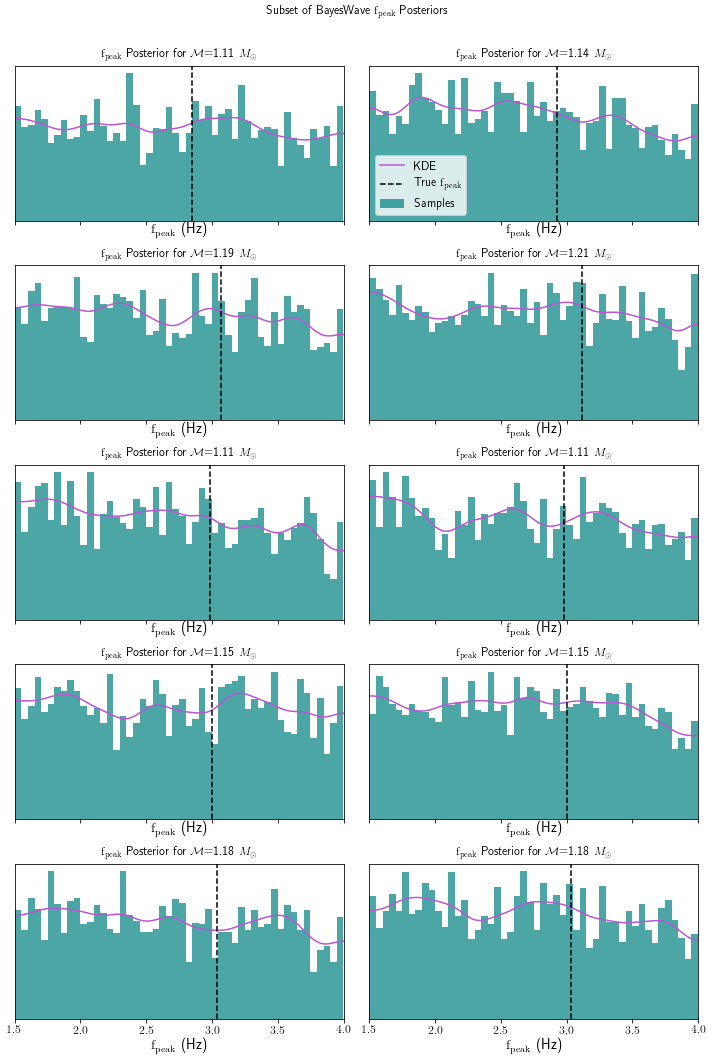

Computing likelihoods...
Creating plots...


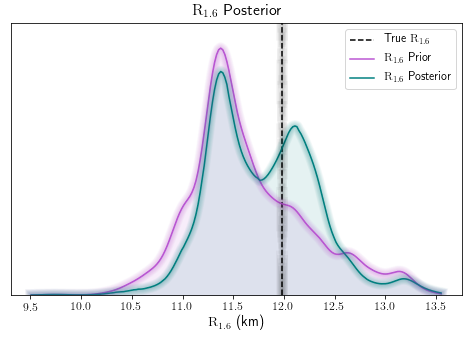

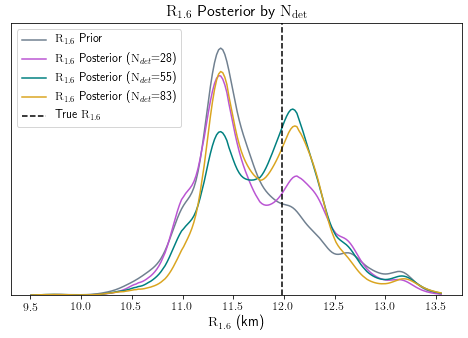

R_1.6 = 11.79 (+1.21,-0.90) km
Saving outputs to ./tutorial_outputs/inline_O5full_RAout/
Saved file to ./tutorial_outputs/inline_O5full_RAout//posterior_eventdict.pickle
Done!


In [39]:
Rs_new,likes_new,post_new,stats_new,postdict_new = run_analysis(O5_datadir,'../priors/fpeak_O4O5_prior.txt',
                                                                '../priors/R16_prior.txt','sfhx',
                                                                '../observing_run_sims/O5_events_updated.csv',
                                                               '../nr_files/sfhx_event_parameters.csv',
                                                               saveto='./tutorial_outputs/inline_O5full_RAout/')

Ta-da!

## Using run_analysis() via the Command Line

Finally, run_analysis() can also be called from the command line and has an inline argument parser. To run the equivalent of the above analysis, do:

```
python3 ../hbpm_analysis.py ../observing_run_sims/O5_sim/ ./observing_run_sims/O5_events_updated.csv ./tutorial_outputs/command_line_O5full_RAout/
```

(the specified paths work from the tutorial folder, otherwise you will need to modify them as needed.)

To get the full list of available options, do:

```
python3 ../hbpm_analysis.py --help
```